In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten,Reshape
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
import csv
from keras.models import Model
#import keras
from keras import backend as k
from keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import scipy
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [4]:
train=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /train.csv')
test=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /test.csv')
print('Train shape:-',train.shape)
print('Test shape:-',test.shape)

Train shape:- (7613, 5)
Test shape:- (3263, 4)


In [5]:
train['keyword']=train['keyword'].fillna('No keyword')
test['keyword']=test['keyword'].fillna('No keyword')

In [6]:
train['location']=train['location'].fillna('No location')
test['location']=test['location'].fillna('No location')

In [7]:
train['text']=train['text']+' '+train['keyword']+' '+train['location']
test['text']=test['text']+' '+test['keyword']+' '+test['location']

In [8]:
import nltk
from tqdm import tqdm
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
            sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed
train['text']=preprocess(train['text'],stopword=False)
test['text']=preprocess(test['text'],stopword=False)

100%|██████████| 3263/3263 [00:00<00:00, 7943.66it/s]


In [10]:
train['len_comm']=train['text'].apply(lambda x:len(x.split()))
test['len_comm']=test['text'].apply(lambda x:len(x.split()))

In [11]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['text'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
train['comp'],train['neg'],train['pos'],train['neu']=generate_sentiment_scores(train)
test['comp'],test['neg'],test['pos'],test['neu']=generate_sentiment_scores(test)

100%|██████████| 3263/3263 [00:02<00:00, 1449.21it/s]


In [13]:
y=train['target']
X=train.drop(['target','id'],axis=1)

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [15]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [16]:
from keras.preprocessing.text import Tokenizer
def text_padding(train,test,test_final,max_len):
    token=Tokenizer()
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    padded_test_final_text=pad_text(test_final,token,max_len)
    return padded_train_text,padded_test_text,padded_test_final_text,token

In [17]:
comm_len=200
train_com_pad,test_com_pad,test_final_com_pad,token_com= text_padding(X_train['text'],X_test['text'],test['text'],comm_len)

In [18]:
def generate_embedding_matrix(token):
    embedding_path='/content/drive/MyDrive/glove.6B.300d.txt'
    embedding_dimension=300
    embedding_index={}
    with open(embedding_path,encoding="utf-8") as f:
         for line in f:
             values=line.split()
             word=values[0]
             coefs=np.asarray(values[1:],dtype='float32')
             embedding_index[word]=coefs
    f.close()        
    embedding_matrix=np.zeros((len(token.word_index)+1,embedding_dimension))
    for word, i in token.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [19]:
embedding_comm_glove = generate_embedding_matrix(token_com)
print(embedding_comm_glove.shape)

(18451, 300)


In [20]:
def generate_embedding_matrix(token):
    embedding_path='/content/drive/MyDrive/wiki-news-300d-1M.vec'
    embedding_dimension=300
    embedding_index={}
    with open(embedding_path,encoding="utf-8") as f:
         for line in f:
             values=line.split()
             word=values[0]
             coefs=np.asarray(values[1:],dtype='float32')
             embedding_index[word]=coefs
    f.close()        
    embedding_matrix=np.zeros((len(token.word_index)+1,embedding_dimension))
    for word, i in token.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [21]:
embedding_comm_wiki = generate_embedding_matrix(token_com)
print(embedding_comm_wiki.shape)

(18451, 300)


In [22]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['comp'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['comp'].values.reshape(-1,1))
test_comp=trans.transform(test['comp'].values.reshape(-1,1))

CPU times: user 4.4 ms, sys: 27 µs, total: 4.43 ms
Wall time: 4.41 ms


In [23]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['neg'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['neg'].values.reshape(-1,1))
test_neg=trans.transform(test['neg'].values.reshape(-1,1))

CPU times: user 3.52 ms, sys: 36 µs, total: 3.55 ms
Wall time: 3.02 ms


In [24]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['pos'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['pos'].values.reshape(-1,1))
test_pos=trans.transform(test['pos'].values.reshape(-1,1))

CPU times: user 2.73 ms, sys: 986 µs, total: 3.72 ms
Wall time: 3.74 ms


In [25]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neu'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neu'].values.reshape(-1,1))
test_neu=trans.transform(test['neu'].values.reshape(-1,1))

CPU times: user 3.73 ms, sys: 0 ns, total: 3.73 ms
Wall time: 3.88 ms


In [26]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_len=trans.fit_transform(X_train['len_comm'].values.reshape(-1,1))
X_test_len=trans.transform(X_test['len_comm'].values.reshape(-1,1))
test_len=trans.transform(test['len_comm'].values.reshape(-1,1))

CPU times: user 2.92 ms, sys: 66 µs, total: 2.98 ms
Wall time: 2.53 ms


In [27]:
%%time
from scipy.sparse import hstack
train_s=np.concatenate((X_train_comp,X_train_neg,X_train_pos,X_train_neu,X_train_len),axis=1)
test_s=np.concatenate((X_test_comp,X_test_neg,X_test_pos,X_test_neu,X_test_len),axis=1)
test_final=np.concatenate((test_comp,test_neg,test_pos,test_neu,test_len),axis=1)

CPU times: user 1.34 ms, sys: 959 µs, total: 2.3 ms
Wall time: 1.65 ms


In [28]:
train_val=[train_com_pad,train_s]
test_val=[test_com_pad,test_s]
test_final_val=[test_final_com_pad,test_final]

In [29]:
from keras.layers import concatenate
def LSTM_Model1(comm_len,token_com):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    
    input5 = Input(shape=(5,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    final_output=Dense(1,activation='sigmoid')(y)
  
    model= Model(inputs=[input_text_1,input5],outputs=final_output)
    return model

In [30]:
model_1=LSTM_Model1(comm_len,token_com)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Comment (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 300)     5535300     ['Comment[0][0]']                
                                                                                                  
 Numerical (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 200, 150)     270600      ['embedding[0][0]']              
                                                                                              

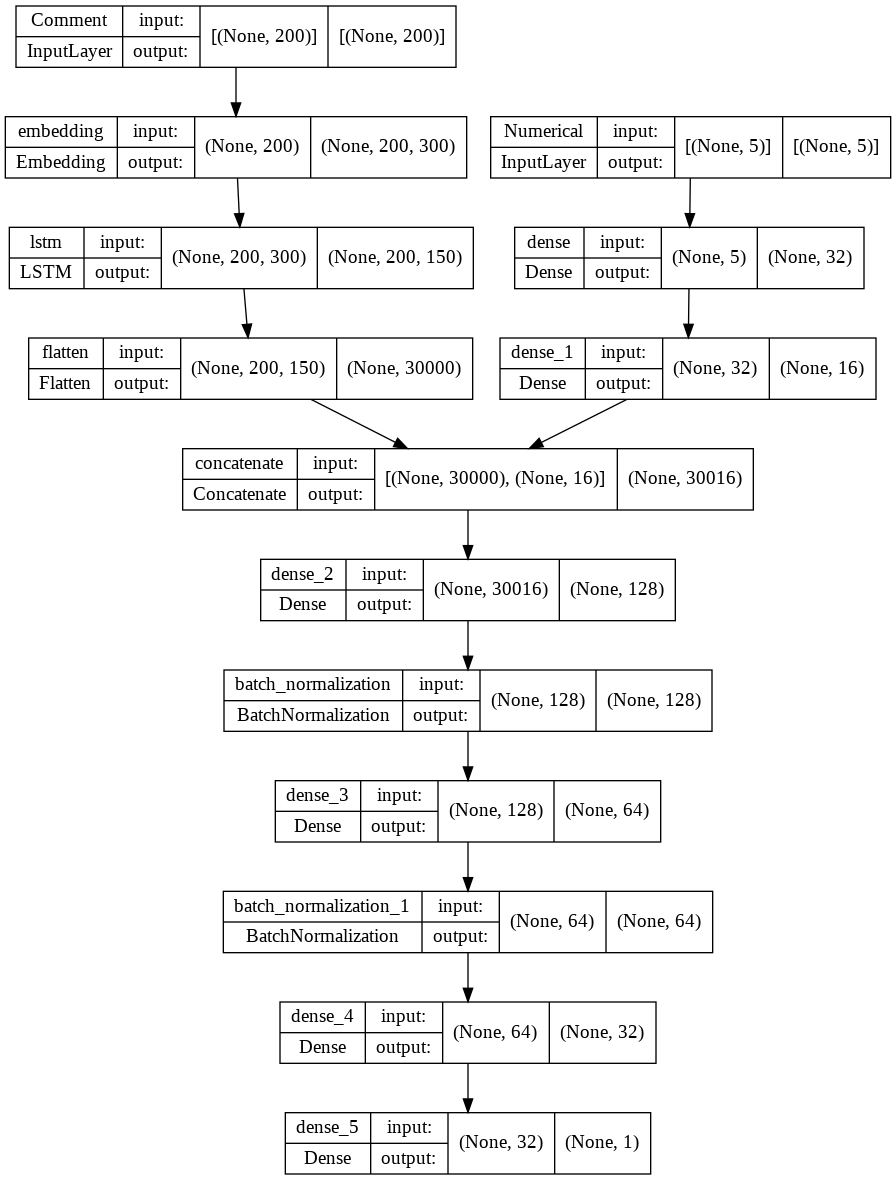

In [31]:
tf.keras.utils.plot_model(
    model_1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [32]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model_1.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
from keras.callbacks import *
import os
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 20,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)

callbacks = [reduce_lr,earlystop]

In [34]:
hitory=model_1.fit(x=train_val,y=y_train,epochs=50,batch_size=128,validation_data=(test_val, y_test),callbacks=callbacks)

Epoch 1/50
42/42 [==============================] - 16s 157ms/step - loss: 4.9644 - accuracy: 0.5494 - val_loss: 4.6331 - val_accuracy: 0.4295 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - 4s 89ms/step - loss: 4.3442 - accuracy: 0.6427 - val_loss: 4.2359 - val_accuracy: 0.4295 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 3.9509 - accuracy: 0.6821
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
42/42 [==============================] - 4s 89ms/step - loss: 3.9509 - accuracy: 0.6821 - val_loss: 3.9240 - val_accuracy: 0.4295 - lr: 1.0000e-04
Epoch 4/50
42/42 [==============================] - 4s 87ms/step - loss: 3.7502 - accuracy: 0.7003 - val_loss: 3.8605 - val_accuracy: 0.4295 - lr: 2.5000e-05
Epoch 5/50
42/42 [==============================] - ETA: 0s - loss: 3.6720 - accuracy: 0.7159
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
42/42 [==============================]

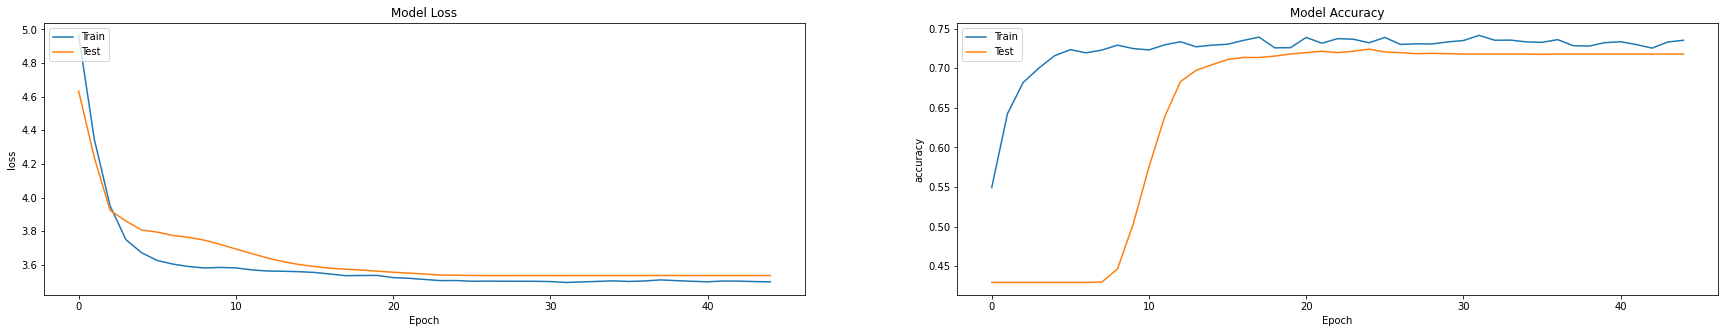

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
def cal(y_pred):
  val=[]
  for value in y_pred:
    if value>=0.5:
      val.append(1)
    else:
      val.append(0)
  return val

In [37]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_val)
    y_predict=cal(y_predict)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (5,5))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

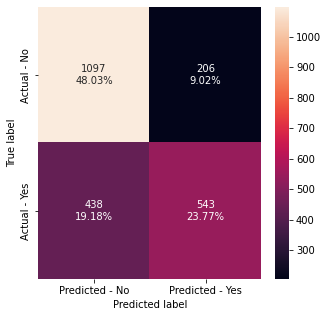

In [38]:
make_confusion_matrix(model_1,y_test,labels=[1, 0])

In [39]:
from keras.layers import concatenate
def LSTM_Model1(comm_len,token_com,embedding_comm_glove):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='text', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm_glove],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    
    input5 = Input(shape=(5,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(1,activation='sigmoid')(y)
  
    model= Model(inputs=[input_text_1,input5],outputs=final_output)
    return model

In [40]:
model_2=LSTM_Model1(comm_len,token_com,embedding_comm_glove)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 300)     5535300     ['text[0][0]']                   
                                                                                                  
 Numerical (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 200, 150)     270600      ['embedding_1[0][0]']            
                                                                                            

In [42]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
#model.compile(loss='mean_squared_error', optimizer=opt)
model_2.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
from keras.callbacks import *
import os
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 20,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
callbacks = [reduce_lr,earlystop]

In [44]:
hitory=model_2.fit(x=train_val,y=y_train,epochs=50,batch_size=128,validation_data=(test_val, y_test),callbacks=callbacks)

Epoch 1/50
42/42 [==============================] - 8s 100ms/step - loss: 4.8222 - accuracy: 0.7435 - val_loss: 4.5744 - val_accuracy: 0.7684 - lr: 0.0100
Epoch 2/50
42/42 [==============================] - 3s 84ms/step - loss: 4.0955 - accuracy: 0.8144 - val_loss: 3.9520 - val_accuracy: 0.7119 - lr: 0.0100
Epoch 3/50
42/42 [==============================] - 3s 81ms/step - loss: 3.4893 - accuracy: 0.8334 - val_loss: 3.3968 - val_accuracy: 0.7815 - lr: 0.0100
Epoch 4/50
42/42 [==============================] - 3s 80ms/step - loss: 2.9712 - accuracy: 0.8566 - val_loss: 2.9441 - val_accuracy: 0.7990 - lr: 0.0100
Epoch 5/50
42/42 [==============================] - 3s 81ms/step - loss: 2.5405 - accuracy: 0.8705 - val_loss: 2.5738 - val_accuracy: 0.7802 - lr: 0.0100
Epoch 6/50
42/42 [==============================] - ETA: 0s - loss: 2.1723 - accuracy: 0.8902
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
42/42 [==============================] - 3s 81ms/step - los

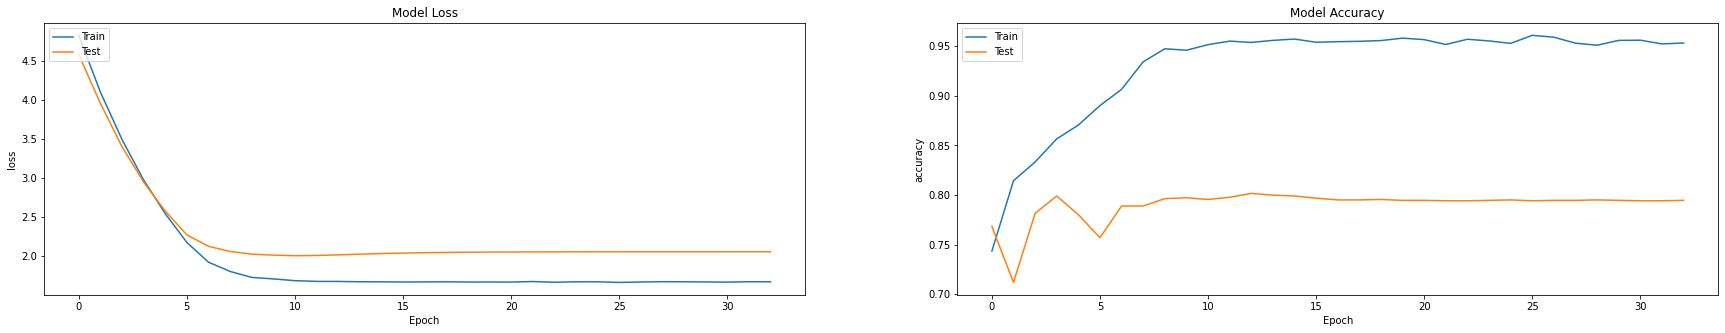

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

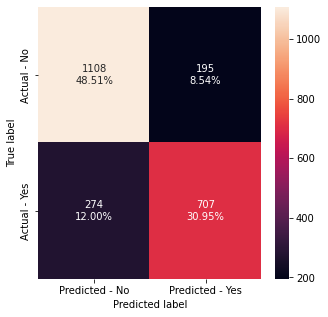

In [46]:
make_confusion_matrix(model_2,y_test,labels=[1, 0])

In [47]:
model_3=LSTM_Model1(comm_len,token_com,embedding_comm_wiki)
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 300)     5535300     ['text[0][0]']                   
                                                                                                  
 Numerical (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 200, 150)     270600      ['embedding_2[0][0]']            
                                                                                            

In [48]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
#model.compile(loss='mean_squared_error', optimizer=opt)
model_3.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

In [49]:
from keras.callbacks import *
import os
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 20,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
callbacks = [reduce_lr,earlystop]

In [50]:
hitory=model_3.fit(x=train_val,y=y_train,epochs=50,batch_size=128,validation_data=(test_val, y_test),callbacks=callbacks)

Epoch 1/50
42/42 [==============================] - 11s 125ms/step - loss: 4.8698 - accuracy: 0.7211 - val_loss: 4.6774 - val_accuracy: 0.5433 - lr: 0.0100
Epoch 2/50
42/42 [==============================] - 4s 85ms/step - loss: 4.1288 - accuracy: 0.8007 - val_loss: 4.0552 - val_accuracy: 0.4527 - lr: 0.0100
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 3.5118 - accuracy: 0.8268
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
42/42 [==============================] - 4s 85ms/step - loss: 3.5118 - accuracy: 0.8268 - val_loss: 3.5028 - val_accuracy: 0.5245 - lr: 0.0100
Epoch 4/50
42/42 [==============================] - 4s 84ms/step - loss: 3.0922 - accuracy: 0.8478 - val_loss: 3.2692 - val_accuracy: 0.7482 - lr: 0.0025
Epoch 5/50
42/42 [==============================] - 4s 87ms/step - loss: 2.9404 - accuracy: 0.8626 - val_loss: 3.1320 - val_accuracy: 0.7846 - lr: 0.0025
Epoch 6/50
42/42 [==============================] - 4s 89ms/step - lo

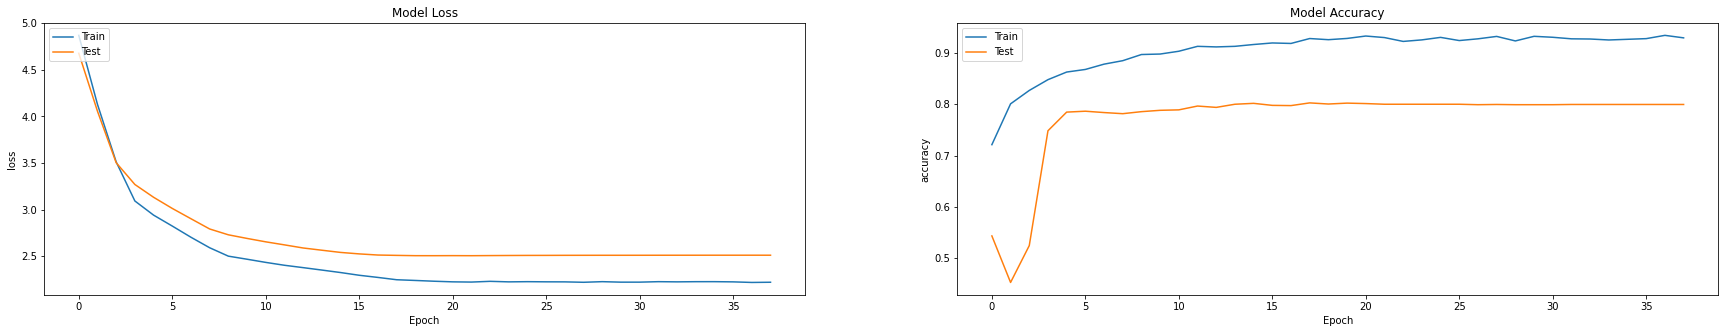

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

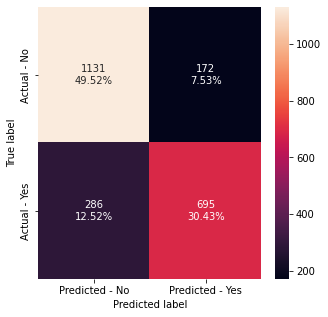

In [52]:
make_confusion_matrix(model_3,y_test,labels=[1, 0])

In [57]:
y_pred=model_2.predict(test_final_val)
y_pred=cal(y_pred)

In [58]:
submission=pd.read_csv('/content/drive/MyDrive/Tweets Disaster /sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [60]:
submission['target']=y_pred
submission.to_csv('final_LSTM_submission_2.csv',index=False)